In [1]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
from sklearn.pipeline import Pipeline
n_clusters = 10
pipeline = Pipeline([('feature_extraction', TfidfVectorizer(max_df=0.4)),
                     ('clusterer', KMeans(n_clusters=n_clusters))
                     ])

In [7]:
import os
import numpy as np
import codecs
data_folder = "textonly/"
documents = [codecs.open(os.path.join(data_folder, filename), encoding='utf8').read() for filename in os.listdir(data_folder)]
len(documents)

476

In [8]:
pipeline.fit(documents)

Pipeline(memory=None,
     steps=[('feature_extraction', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.4, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smo...n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0))])

In [9]:
labels = pipeline.predict(documents)

In [10]:
from collections import Counter
c = Counter(labels)
for cluster_number in range(n_clusters):
    print("Cluster {} contains {} samples".format(cluster_number, c[cluster_number]))

Cluster 0 contains 25 samples
Cluster 1 contains 34 samples
Cluster 2 contains 91 samples
Cluster 3 contains 24 samples
Cluster 4 contains 19 samples
Cluster 5 contains 201 samples
Cluster 6 contains 8 samples
Cluster 7 contains 16 samples
Cluster 8 contains 27 samples
Cluster 9 contains 31 samples


In [11]:
pipeline.named_steps['clusterer'].inertia_

401.7616862698829

In [12]:
inertia_scores = []
n_cluster_values = list(range(2, 20))
for n_clusters in n_cluster_values:
    cur_inertia_scores = []
    X = TfidfVectorizer(max_df=0.4).fit_transform(documents)
    for i in range(30):
        km = KMeans(n_clusters=n_clusters).fit(X)
        cur_inertia_scores.append(km.inertia_)
    inertia_scores.append(cur_inertia_scores)
inertia_scores = np.array(inertia_scores)

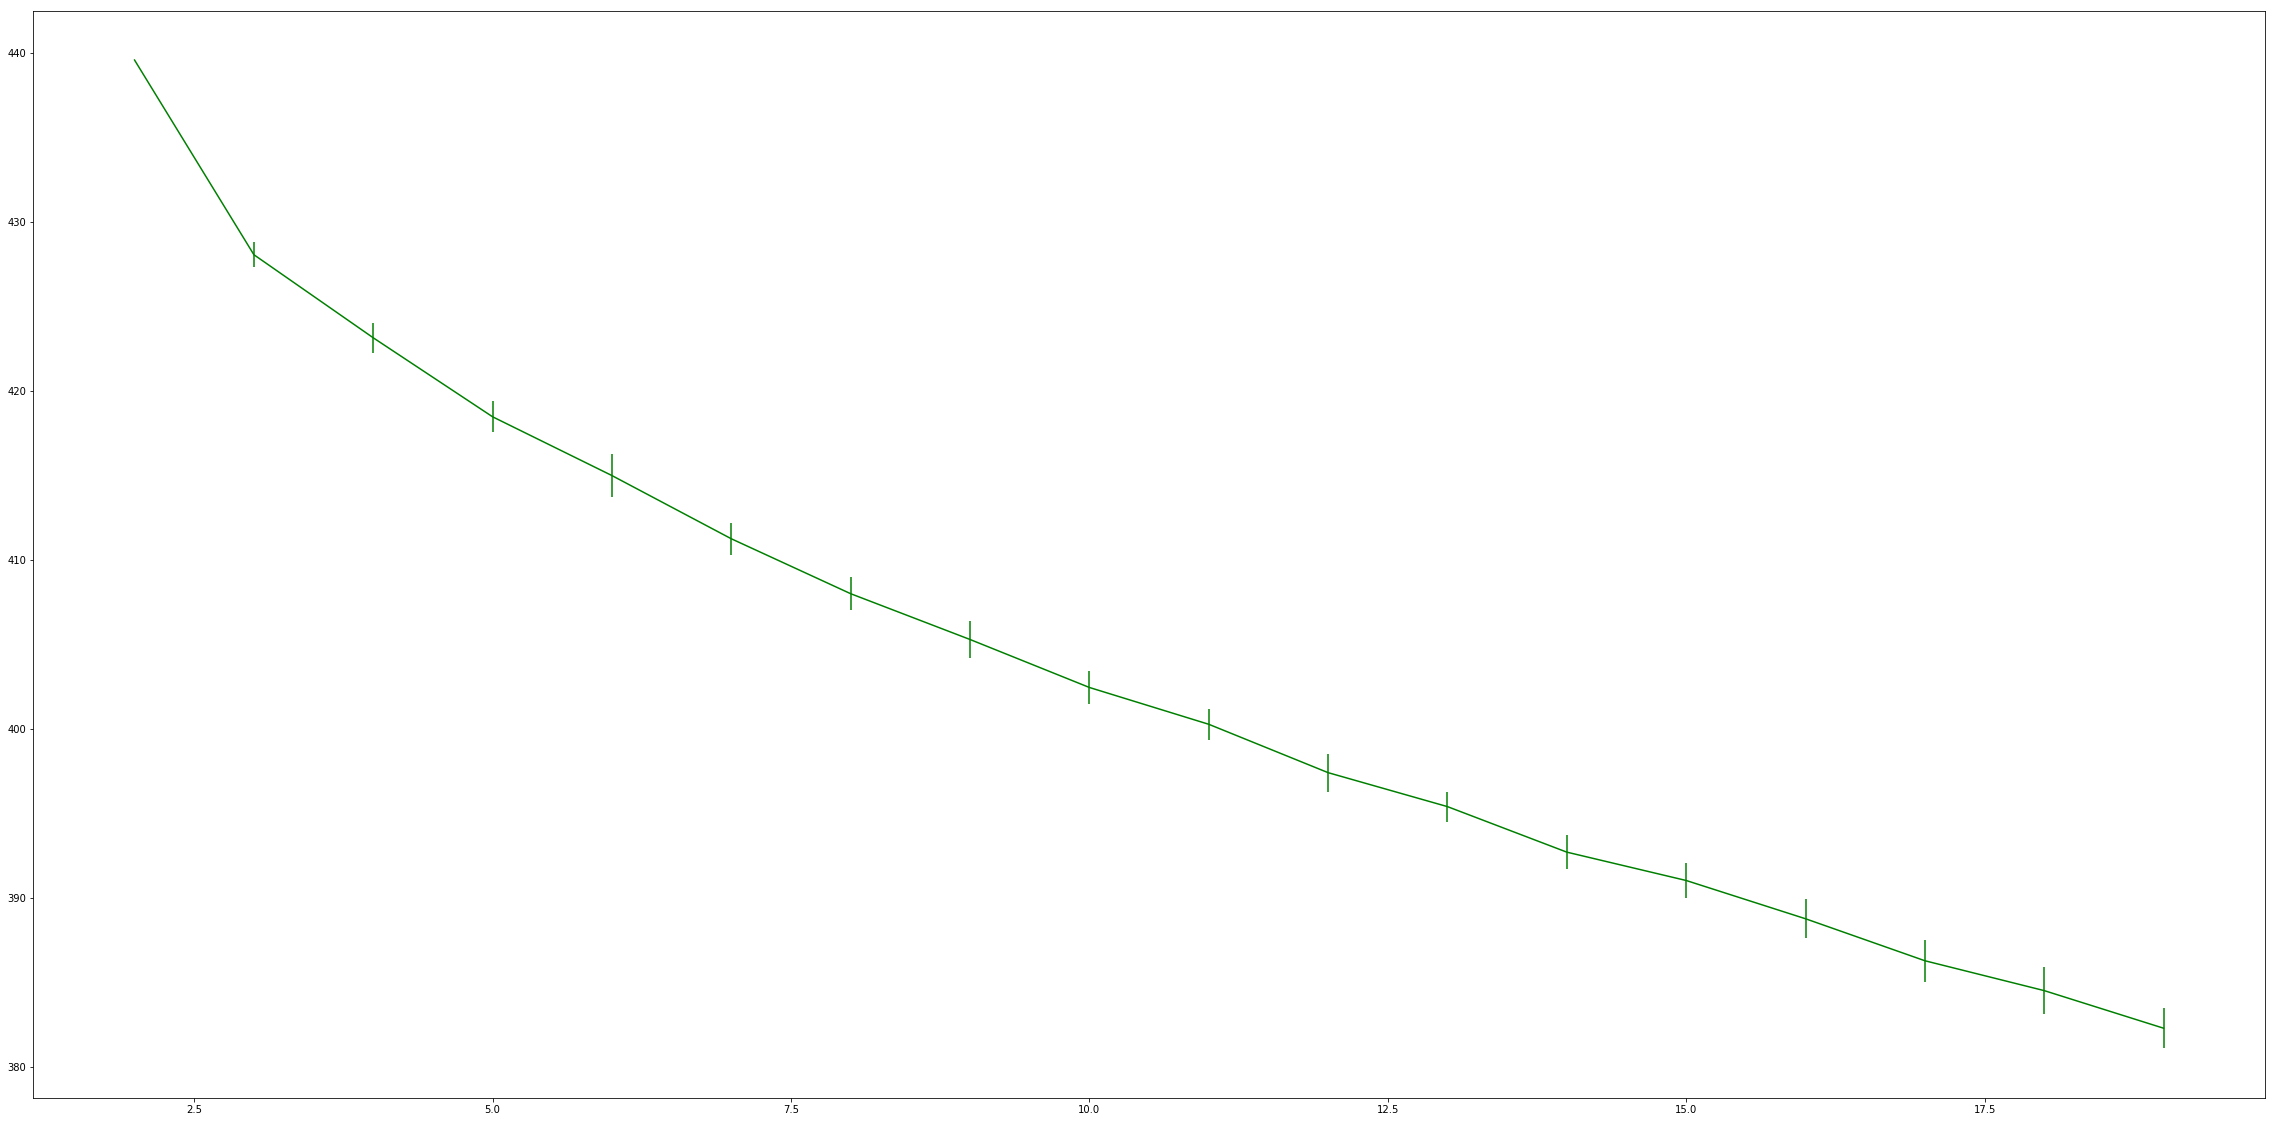

In [13]:
%matplotlib inline
from matplotlib import pyplot as plt

inertia_means = np.mean(inertia_scores, axis=1)
inertia_stderr = np.std(inertia_scores, axis=1)

fig = plt.figure(figsize=(40,20))
plt.errorbar(n_cluster_values, inertia_means, inertia_stderr, color='green')
plt.show()

In [14]:
n_clusters = 6

pipeline = Pipeline([('feature_extraction', TfidfVectorizer(max_df=0.4)),
                     ('clusterer', KMeans(n_clusters=n_clusters))
                     ])
pipeline.fit(documents)

Pipeline(memory=None,
     steps=[('feature_extraction', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.4, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smo...n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0))])

In [15]:
labels = pipeline.predict(documents)

In [16]:
c = Counter(labels)

terms = pipeline.named_steps['feature_extraction'].get_feature_names()

for cluster_number in range(n_clusters):
    print("Cluster {} contains {} samples".format(cluster_number, c[cluster_number]))
    print("  Most important terms")
    centroid = pipeline.named_steps['clusterer'].cluster_centers_[cluster_number]
    most_important = centroid.argsort()
    for i in range(5):
        term_index = most_important[-(i+1)]
        print("  {0}) {1} (score: {2:.4f})".format(i+1, terms[term_index], centroid[term_index]))
    print()

Cluster 0 contains 20 samples
  Most important terms
  1) ice (score: 0.1142)
  2) temperatures (score: 0.1009)
  3) climate (score: 0.0916)
  4) heat (score: 0.0820)
  5) temperature (score: 0.0791)

Cluster 1 contains 34 samples
  Most important terms
  1) hong (score: 0.3263)
  2) kong (score: 0.3254)
  3) protesters (score: 0.1786)
  4) police (score: 0.1600)
  5) china (score: 0.0933)

Cluster 2 contains 35 samples
  Most important terms
  1) deal (score: 0.1714)
  2) brexit (score: 0.1423)
  3) johnson (score: 0.1306)
  4) eu (score: 0.1203)
  5) uk (score: 0.0667)

Cluster 3 contains 31 samples
  Most important terms
  1) your (score: 0.3409)
  2) ua34 (score: 0.2641)
  3) signature (score: 0.2598)
  4) browser (score: 0.2382)
  5) owner (score: 0.2367)

Cluster 4 contains 19 samples
  Most important terms
  1) navalny (score: 0.2716)
  2) moscow (score: 0.2116)
  3) opposition (score: 0.1474)
  4) candidates (score: 0.0975)
  5) police (score: 0.0891)

Cluster 5 contains 337 sa

In [17]:
from sklearn.metrics import silhouette_score
X = pipeline.named_steps['feature_extraction'].transform(documents)
silhouette_score(X, labels)

0.04811340697715151

In [18]:
Y = pipeline.transform(documents) 

In [19]:
km = KMeans(n_clusters=n_clusters)
labels = km.fit_predict(Y)

In [20]:
c = Counter(labels)
for cluster_number in range(n_clusters):
    print("Cluster {} contains {} samples".format(cluster_number, c[cluster_number]))

Cluster 0 contains 34 samples
Cluster 1 contains 31 samples
Cluster 2 contains 340 samples
Cluster 3 contains 34 samples
Cluster 4 contains 18 samples
Cluster 5 contains 19 samples


In [21]:
silhouette_score(Y, labels)

0.6826750153590618

In [22]:
Y.shape

(476, 6)

In [23]:
from scipy.sparse import csr_matrix

In [24]:
def create_coassociation_matrix(labels):
    rows = []
    cols = []
    unique_labels = set(labels)
    for label in unique_labels:
        indices = np.where(labels == label)[0]
        for index1 in indices:
            for index2 in indices:
                rows.append(index1)
                cols.append(index2)
    data = np.ones((len(rows),))
    return csr_matrix((data, (rows, cols)), dtype='float')

In [25]:
C = create_coassociation_matrix(labels)

In [26]:
C

<476x476 sparse matrix of type '<class 'numpy.float64'>'
	with 119558 stored elements in Compressed Sparse Row format>

In [27]:
C.shape, C.shape[0] * C.shape[1]

((476, 476), 226576)

In [28]:
len(C.nonzero()[0]) / (C.shape[0] * C.shape[1])

0.5276728338394181

In [29]:
print(C)

  (0, 0)	1.0
  (0, 2)	1.0
  (0, 3)	1.0
  (0, 4)	1.0
  (0, 6)	1.0
  (0, 7)	1.0
  (0, 8)	1.0
  (0, 9)	1.0
  (0, 10)	1.0
  (0, 11)	1.0
  (0, 14)	1.0
  (0, 15)	1.0
  (0, 17)	1.0
  (0, 18)	1.0
  (0, 21)	1.0
  (0, 24)	1.0
  (0, 25)	1.0
  (0, 26)	1.0
  (0, 28)	1.0
  (0, 29)	1.0
  (0, 31)	1.0
  (0, 32)	1.0
  (0, 33)	1.0
  (0, 34)	1.0
  (0, 40)	1.0
  :	:
  (475, 167)	1.0
  (475, 173)	1.0
  (475, 180)	1.0
  (475, 186)	1.0
  (475, 202)	1.0
  (475, 245)	1.0
  (475, 251)	1.0
  (475, 276)	1.0
  (475, 283)	1.0
  (475, 300)	1.0
  (475, 305)	1.0
  (475, 320)	1.0
  (475, 332)	1.0
  (475, 345)	1.0
  (475, 350)	1.0
  (475, 372)	1.0
  (475, 382)	1.0
  (475, 395)	1.0
  (475, 404)	1.0
  (475, 424)	1.0
  (475, 442)	1.0
  (475, 447)	1.0
  (475, 453)	1.0
  (475, 461)	1.0
  (475, 475)	1.0


In [30]:
from scipy.sparse.csgraph import minimum_spanning_tree

In [31]:
mst = minimum_spanning_tree(C)

In [32]:
mst

<476x476 sparse matrix of type '<class 'numpy.float64'>'
	with 470 stored elements in Compressed Sparse Row format>

In [33]:
pipeline = Pipeline([('feature_extraction', TfidfVectorizer(max_df=0.4)),
                     ('clusterer', KMeans(n_clusters=3))
                     ])
pipeline.fit(documents)
labels2 = pipeline.predict(documents)
C2 = create_coassociation_matrix(labels2)

In [34]:
C_sum = (C + C2) / 2
#C_sum.data = C_sum.data
C_sum.todense()

matrix([[1., 0., 1., ..., 1., 1., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [1., 0., 1., ..., 1., 1., 0.],
        ...,
        [1., 0., 1., ..., 1., 1., 0.],
        [1., 0., 1., ..., 1., 1., 0.],
        [0., 0., 0., ..., 0., 0., 1.]])

In [35]:
mst = minimum_spanning_tree(-C_sum)
mst

<476x476 sparse matrix of type '<class 'numpy.float64'>'
	with 473 stored elements in Compressed Sparse Row format>

In [36]:
mst.data[mst.data > -1] = 0
mst.eliminate_zeros()
mst

<476x476 sparse matrix of type '<class 'numpy.float64'>'
	with 470 stored elements in Compressed Sparse Row format>

In [37]:
from scipy.sparse.csgraph import connected_components
number_of_clusters, labels = connected_components(mst)

In [38]:
print(number_of_clusters)

6


In [39]:
from sklearn.base import BaseEstimator, ClusterMixin

class EAC(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusterings=10, cut_threshold=0.5, n_clusters_range=(3, 10)):
        self.n_clusterings = n_clusterings
        self.cut_threshold = cut_threshold
        self.n_clusters_range = n_clusters_range
    
    def fit(self, X, y=None):
        C = sum((create_coassociation_matrix(self._single_clustering(X))
                 for i in range(self.n_clusterings)))
        mst = minimum_spanning_tree(-C)
        mst.data[mst.data > -self.cut_threshold] = 0
        mst.eliminate_zeros()
        self.n_components, self.labels_ = connected_components(mst)
        return self
    
    def _single_clustering(self, X):
        n_clusters = np.random.randint(*self.n_clusters_range)
        km = KMeans(n_clusters=n_clusters)
        return km.fit_predict(X)
    
    def fit_predict(self, X):
        self.fit(X)
        return self.labels_

In [40]:
pipeline = Pipeline([('feature_extraction', TfidfVectorizer(max_df=0.4)),
                     ('clusterer', EAC())
                     ])

In [41]:
pipeline.fit(documents)

Pipeline(memory=None,
     steps=[('feature_extraction', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.4, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smo...ocabulary=None)), ('clusterer', EAC(cut_threshold=0.5, n_clusterings=10, n_clusters_range=(3, 10)))])

In [42]:
labels = pipeline.named_steps['clusterer'].labels_

In [43]:
c = Counter(labels)

In [44]:
c

Counter({0: 445, 1: 31})

In [45]:
from sklearn.cluster import MiniBatchKMeans

In [46]:
vec = TfidfVectorizer(max_df=0.4)

In [47]:
X = vec.fit_transform(documents)

In [48]:
mbkm = MiniBatchKMeans(random_state=14, n_clusters=3)
batch_size = 500

indices = np.arange(0, X.shape[0])
for iteration in range(100):
    sample = np.random.choice(indices, size=batch_size, replace=True)
    mbkm.partial_fit(X[sample[:batch_size]])

In [49]:
labels_mbkm = mbkm.predict(X)
mbkm.inertia_

457.5033769791245

In [50]:
km = KMeans(random_state=14, n_clusters=3)
labels_km = km.fit_predict(X)
km.inertia_

427.6381330090035

In [51]:
from sklearn.metrics import adjusted_mutual_info_score, homogeneity_score
from sklearn.metrics import mutual_info_score, v_measure_score

In [52]:
v_measure_score(labels_mbkm, labels_km)

0.42076818047045456

In [53]:
from sklearn.feature_extraction.text import HashingVectorizer

In [54]:
class PartialFitPipeline(Pipeline):
    def partial_fit(self, X, y=None):
        Xt = X
        for name, transform in self.steps[:-1]:
            Xt = transform.transform(Xt)
        return self.steps[-1][1].partial_fit(Xt, y=y)

In [55]:
pipeline = PartialFitPipeline([('feature_extraction', HashingVectorizer()),
                             ('clusterer', MiniBatchKMeans(random_state=14, n_clusters=3))
                             ])

In [56]:
batch_size = 10

for iteration in range(int(len(documents) / batch_size)):
    start = batch_size * iteration
    end = batch_size * (iteration + 1)
    pipeline.partial_fit(documents[start:end])

In [57]:
labels = pipeline.predict(documents)
labels

array([0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0,